# Dataiku Exercise - Income Prediction on US Census Dataset
### Candidate : Jianzhong Liang

### Requirements:
Work with R or Python to carry out the following steps:
* Import the learning and text files
* Based on the learning file:
    * Make a quick statistic based and univariate audit of the different columns’ content and produce the results in visual / graphic format. This audit should describe the variable distribution, the % of missing values, the extreme values, and so on.
    * Create a model using these variables (you can use whichever variables.
    * Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction. 
    * Apply your model to the test file and measure it’s real performance on it (same method as above).


The goal of this exercise is not to create the best or the purest model, but rather to describe the steps you took to accomplish it.

* Explain areas that may have been the most challenging for you.

* Find clear insights on the profiles of the people that make more than $50,000 / year. For example, which variables seem to be the most correlated with this phenomenon?



In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, Imputer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV


path_trainset = 'us_census_full/census_income_learn.csv'
path_testset = 'us_census_full/census_income_test.csv'

## 1. Import data

In [2]:
# quick look on the data file format, separator, header
! head -1 us_census_full/census_income_learn.csv

73, Not in universe, 0, 0, High school graduate, 0, Not in universe, Widowed, Not in universe or children, Not in universe, White, All other, Female, Not in universe, Not in universe, Not in labor force, 0, 0, 0, Nonfiler, Not in universe, Not in universe, Other Rel 18+ ever marr not in subfamily, Other relative of householder, 1700.09, ?, ?, ?, Not in universe under 1 year old, ?, 0, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in universe, 2, 0, 95, - 50000.


In [3]:
# load data
df_train = pd.read_csv(path_trainset, sep=',', header =None)
df_test = pd.read_csv(path_testset, sep=',', header =None)
header = ['AGE', 'CLSWKR', 'INDUSTRY', 'OCCUPATION', 'EDU', 'WAGE', 'SCHOOL ATTENDING', 'MARRIAGE', 'INDUSTRY CODE', 'OCCUPATION CODE', 'RACE', 'HISPANIC ORI', 'SEX', 'MEM UNION', 
          'UNEMPLOY REASON', 'EMPLOYMENT STATUS', 'CAPGAIN', 'CAPLOSS' , 'DIVIDENT','FEDTAX', 'TAX FILLER', 'PREVIOUS STATE', 'HOUSEHOLD STATUS', 'FAMILY STATUS', 'WEIGHT', 'MIGRANT  (MSA)', 
          'MIGRANT (REG)', 'MIGRANT (WITHIN REG)', 'LIVE IN HOUSE', 'LIVE IN SUNBELT', 'NUM EMPLOYEES', 'PARENT PRESENTED', 'FATHER COUNTRY', 'MOTHER COUNTRY', 'SELF COUNTRY',
          'CITIZEN', 'OWN BUSINESS', 'VETERAN QUESIONAIRES', 'VETERAN BENEFIT', 'WORK WEEKs IN YEAR', 'YEAR', 'EARN']
df_train.columns = header
df_test.columns = header

In [4]:
df_train.head(3)

,AGE,CLSWKR,INDUSTRY,OCCUPATION,EDU,WAGE,SCHOOL ATTENDING,MARRIAGE,INDUSTRY CODE,OCCUPATION CODE,...,FATHER COUNTRY,MOTHER COUNTRY,SELF COUNTRY,CITIZEN,OWN BUSINESS,VETERAN QUESIONAIRES,VETERAN BENEFIT,WORK WEEKs IN YEAR,YEAR,EARN
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


## 2. Descriptive statistics about the data

### 2.1 Missing Values

In [5]:
# count the missing values and remove columns without missing values
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing

Series([], dtype: int64)

<div class="alert alert-success">
**COMMENT**<br>
I found two caveats here:<br><br>
1. As show in above cell, firstly I got zero missing value, so I tried to read the metadata description but found nothing about missing value format.<br>
Therefore looked into the data file, and found " ?" invalid value.<br>
<br>
2. If in pd.read_csv(), we set "skipinitialspace = True", 
the "NA" value in "hispanic Origin" column would tend to be interpreted as invalid NaN, which is not correct.
we need to also set "keep_default_na = False"
</div>

In [6]:
# find all the missing values in trainset
df_train = df_train.replace(" ?",np.NaN)
missing1 = df_train.isnull().sum()
missing1 = missing1[missing1 > 0]
missing1

PREVIOUS STATE            708
MIGRANT  (MSA)          99696
MIGRANT (REG)           99696
MIGRANT (WITHIN REG)    99696
LIVE IN SUNBELT         99696
FATHER COUNTRY           6713
MOTHER COUNTRY           6119
SELF COUNTRY             3393
dtype: int64

In [7]:
# find all the missing values in testset
df_test = df_test.replace(" ?",np.NaN)
missing2 = df_test.isnull().sum()
missing2 = missing2[missing2 > 0]
missing2

PREVIOUS STATE            330
MIGRANT  (MSA)          49946
MIGRANT (REG)           49946
MIGRANT (WITHIN REG)    49946
LIVE IN SUNBELT         49946
FATHER COUNTRY           3429
MOTHER COUNTRY           3072
SELF COUNTRY             1764
dtype: int64

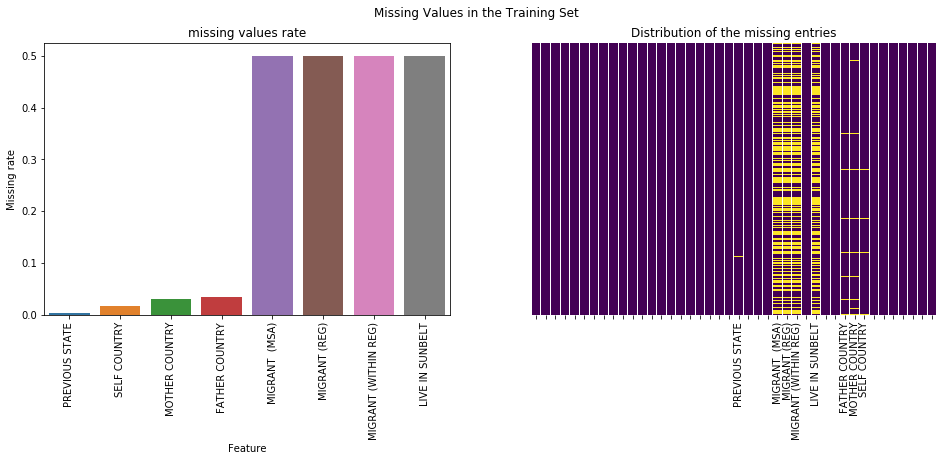

In [8]:
# Visulize the missing data
# sort by number of missing values
missing1.sort_values(inplace=True)
# get the feature type from the index and create a the missing values DataFrame
missingDF = pd.DataFrame(list(zip(missing1.index.values, missing1.values/len(df_train.index))), 
                         columns=['Feature', 'Missing rate'])

_, ax = plt.subplots(1, 2, figsize=(16, 5))

# display the missing values per category
sns.barplot(x='Feature', 
            y='Missing rate',  
            data=missingDF, 
            ax=ax[0], 
            dodge=False)
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('missing values rate')


# create a list containing emty spaces or features with missing entries
label_mis = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_mis.append(col)
    else:
        label_mis.append("")

# display the position of the missing entries
sns.heatmap(df_train.isnull(), 
            yticklabels=False, 
            xticklabels=label_mis, 
            cbar = False, 
            cmap='viridis', 
            ax = ax[1])
ax[1].set_title('Distribution of the missing entries')

plt.suptitle('Missing Values in the Training Set')
plt.show()

<div class="alert alert-success">
**COMMENT**<br>
Test and Train have the same missing pattern.<br>
Two interesting points here:<br>
1.There 8 features have missing values, all of them are categorical features, the missing rate can be found in above.<br>
2. Four features have the same missing rate, and the missing values have the same distribution(missing for the same row).<br>


This missing values is not due to the "bad encoding of the information", where missing == value "Unknow".
Beacuse in the metadata, I found that there are already values for "Unknow", like "Not in universe", "All other".
</div>

### 2.2 Features distribution

### 2.2.1 Labels distribution

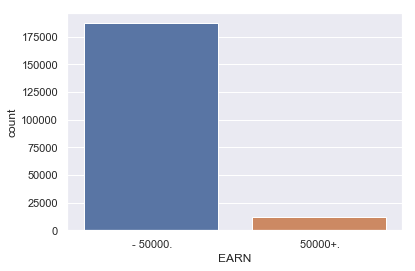

In [9]:
sns.set()
sns.countplot(df_train.EARN)
plt.show()

<div class="alert alert-success">
**COMMENT**<br>
We found that the labels are very imbalanced.<br>
This tells us that when we evulate our model later, the measurement "Accuracy" is not enough, we should also use  "Precision" and "Recall" or F1 score due to the imbalance.

After look into the metadata, I subdivide features in three main sets:
 - <b>Categorical</b> or nominal features are qualitative variables that can only be counted, they have no order or intervals(e.g. citizenship, race, all the nominal features except two about education)
 
 - <b>Ordinal</b> features are qualitative variables that have a concept of order so that they can be organized in a sequence or ranked(e.g. education, enroll in edu inst last wk)
 
 - <b>Numerical</b> features include both interval features, ordinal variables that hold a measure of interval between items (e.g. weeks worked in year, all the continuous features).
 
For each features type we should treat them differently, like when we encode the Ordinal features, we should keep the order of featrues. 


In [10]:
# group features
ls_numerical_features = df_train.select_dtypes(include=[np.dtype('int64'), np.dtype('float64')]).columns
ls_categorical_features = df_train.select_dtypes(include=[np.dtype('object')]).drop(['EDU', "SCHOOL ATTENDING", "EARN"] , axis=1).columns
ls_ordinal_features = df_train[['EDU', "SCHOOL ATTENDING"]].columns
nominal_selected_features = ['EDU', "SEX", "OCCUPATION", 'INDUSTRY']
numerical_selected_features = ["AGE", "WAGE", "CAPGAIN", "CAPLOSS", "DIVIDENT", "WEIGHT"]

### 2.2.2 Categorical & Ordinal Features

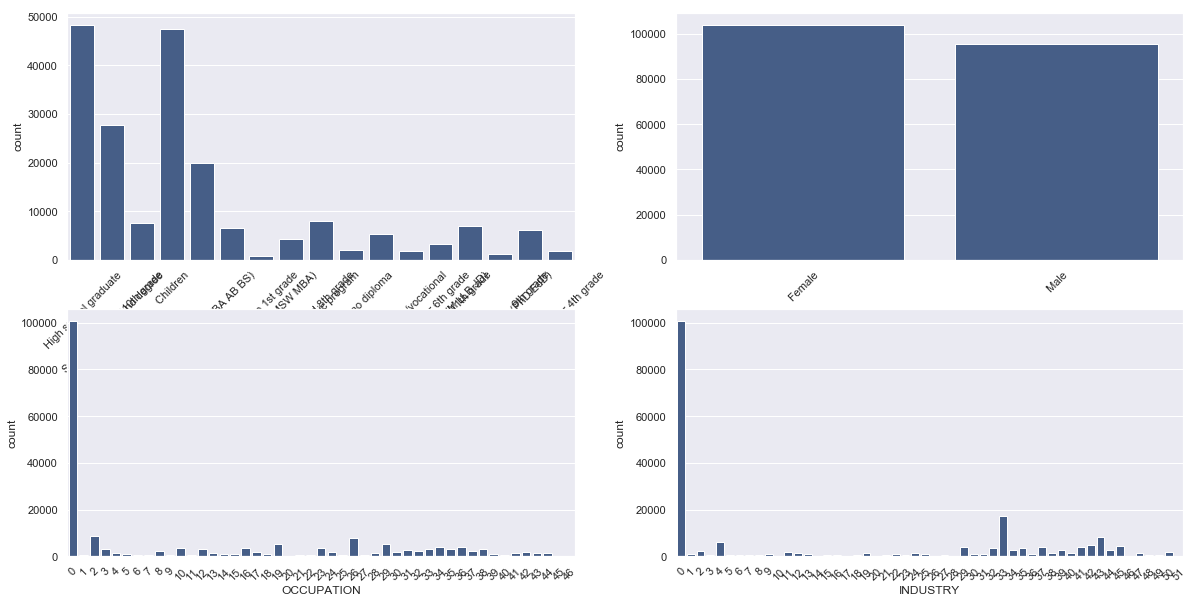

In [11]:
# visualize the histogram
_, ax = plt.subplots(2, 2, figsize=(20,10))
for i,featureName in enumerate(nominal_selected_features):   
    # plot the count plot
    fig = sns.countplot(x= featureName, data = df_train,  ax = ax[int(i/2)][i%2], color = sns.xkcd_rgb["denim blue"])
    for tick in ax[int(i/2)][i%2].get_xticklabels():
        tick.set_rotation(45)
plt.show()

In [12]:
def get_segemented_bar(col1, col2):
    cross_tables = pd.crosstab(col1, col2)
    counts = cross_tables.sum(axis = 1).astype(float)
    return cross_tables.div(counts, axis = 0)

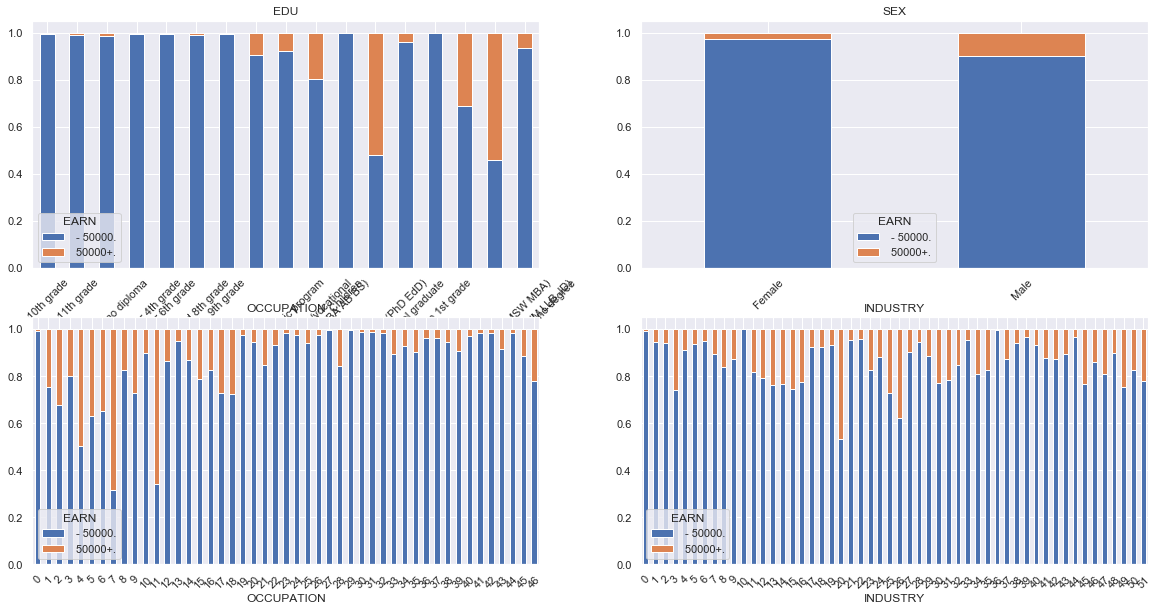

In [13]:
# visualize the segemented bar
_, ax = plt.subplots(2, 2, figsize=(20,10))
for i,featureName in enumerate(nominal_selected_features): 
    # plot the count plot
    segemented_bar = get_segemented_bar(df_train[featureName],df_train['EARN'])
    segemented_bar.plot(kind='bar', stacked=True, title=featureName, ax = ax[int(i/2)][i%2])
    for tick in ax[int(i/2)][i%2].get_xticklabels():
        tick.set_rotation(45)
plt.show()

<div class="alert alert-success">
**COMMENT**<br>
1. For **Categorical** and **Ordinal** feature we could use two plot for analysis:
 * **Histogram**: to find the categories distribution within a feature.
 * **Segemented bar chart**: to show the conditional distributions of label on each category value.
 
2. In histogram many features show a distribution mainly concentrated on few categories. This could lead to very poor correlation, especially when just a few samples belong to other categories.<br>

3. In Segemented bar, some features have similar conditional distribution across categories(e.g. LIVE IN HOUSE)which may not give a lot help in prediction, but features with different distribution (e.g. SEX) would contain more information for prediction.

4. I treat "occupation recode" and "industry code" as nominal data here though they are int data type, since those number don't contain "order information". And from the Segemented bar above we can also see that the order of the number have no relationship with the label conditional distribution. 

### 2.2.3 Numerical Features

In [14]:
df_train[numerical_selected_features].describe()

,AGE,WAGE,CAPGAIN,CAPLOSS,DIVIDENT,WEIGHT
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1740.380269
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,993.768156
min,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,1061.615000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1618.310000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,2188.610000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000


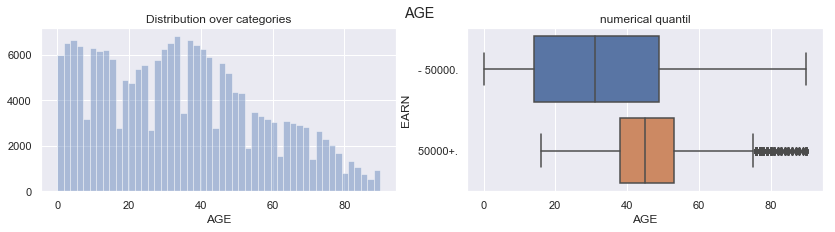

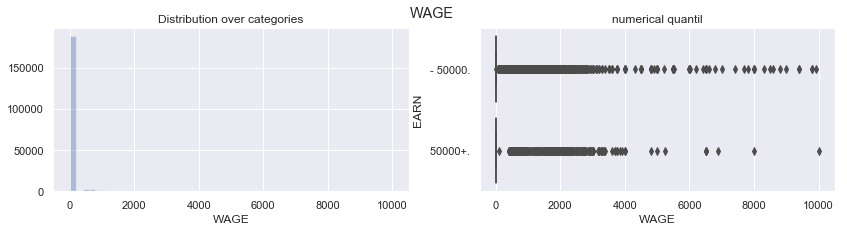

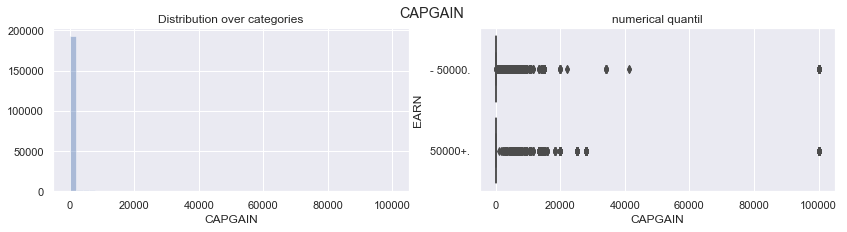

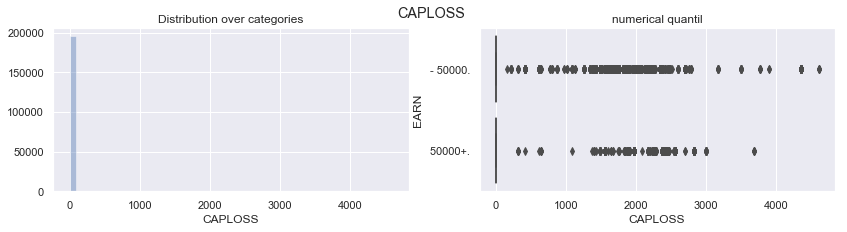

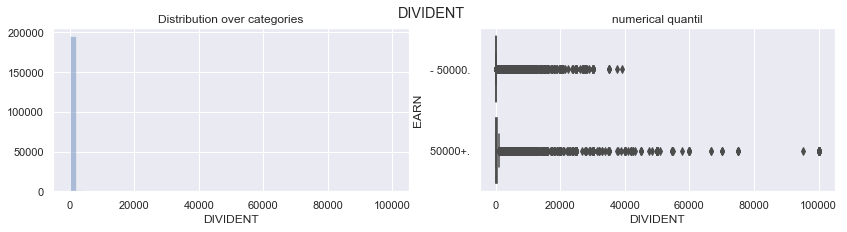

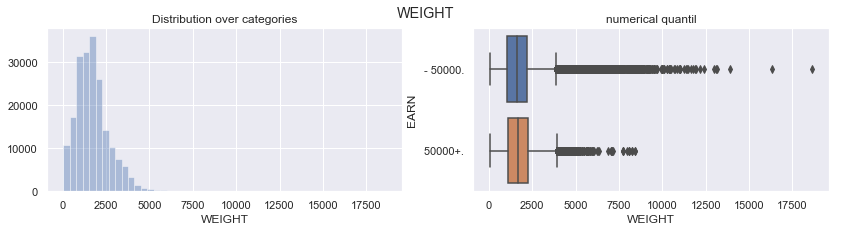

In [15]:
# try to visualize the numerical features
encode_labels = df_train["EARN"].astype('category').cat.codes
count = 0
missing = []
for featureName in numerical_selected_features:
    _, ax = plt.subplots(1, 2, figsize=(14, 3))

    # plot the distribution
    sns.distplot(df_train[featureName], 
                 kde=False,
                 ax=ax[0])
    ax[0].set_title("Distribution over categories")

    # scatter plot
    sns.boxplot(x = df_train[featureName], 
                y = df_train["EARN"],
                ax = ax[1])
    ax[1].set_title("numerical quantil")

    plt.suptitle(featureName)
    plt.show()

    count += 1

<div class="alert alert-success">
**COMMENT**<br>
1. For numerical feature i choose **Histogram** and **Boxplot** to show: **Distribution, Extreme value, Quantile, relation with label.**
<br>
2. Larger Age will have more possiblitiy for 50k+ salary, while feature WEIGHT could not give us a lot information about salary labels.
<br>
3. GAPLOSS and other 3 features is very concentrated on one value, which also can't  give a lot information.




## 3. Features Engineering

### 3.1 Filling missing values
<div class="alert alert-success">
**COMMENT**<br>
* For "PREVIOUS STATE, MIGRANT  (MSA), MIGRANT (REG), MIGRANT (WITHIN REG), LIVE IN SUNBELT" since they are missing in the same row(we can not use one to estimate another) and there is a category call " Not identifiable", we fill all missings as " Not identifiable".
* For "FATHER COUNTRY, MOTHER COUNTRY, SELF COUNTRY" we fill each other in the same row, like if SELF COUNTRY is missing but FATHER COUNTRY is not, we let SELF COUNTRY = FATHER COUNTRY.

In [16]:
# fill NaN
ls1 = ['PREVIOUS STATE','MIGRANT  (MSA)', 'MIGRANT (REG)', 'MIGRANT (WITHIN REG)','LIVE IN SUNBELT']
ls2 = ['SELF COUNTRY', 'MOTHER COUNTRY', 'FATHER COUNTRY']
for col in ls1:
    df_train[col] = df_train[col].replace(np.NaN, ' Not in universe')
    
    df_test[col] = df_test[col].replace(np.NaN, ' Not in universe')
    
for col in ls2:
    df_train[col] = df_train[col].fillna(df_train['SELF COUNTRY'])
    df_train[col] = df_train[col].fillna(df_train['MOTHER COUNTRY'])
    df_train[col] = df_train[col].fillna(df_train['FATHER COUNTRY'])
    df_train[col] = df_train[col].fillna(' Not in universe')
    
    df_test[col] = df_test[col].fillna(df_test['SELF COUNTRY'])
    df_test[col] = df_test[col].fillna(df_test['MOTHER COUNTRY'])
    df_test[col] = df_test[col].fillna(df_test['FATHER COUNTRY'])
    df_test[col] = df_test[col].fillna(' Not in universe')

In [17]:
# check if still have NaN
missing2 = df_train.isnull().sum()
missing3 = df_test.isnull().sum()
print("Now there is {} missings in train, and {} missings in test".
      format(len(missing2[missing2 > 0]), len(missing3[missing3 > 0])))

Now there is 0 missings in train, and 0 missings in test


In [18]:
len(df_train.columns) == len(df_test.columns)

True

### 3.2 Re-order the numerical encoding 

In [19]:
def re_order_encoding(col1, col2):
    values = get_segemented_bar(col1,col2)
    values_sorted = values.sort_values(by = ' 50000+.').index.tolist()
    valuse_original = np.sort(col1.unique())
    return col1.replace(values_sorted,valuse_original)

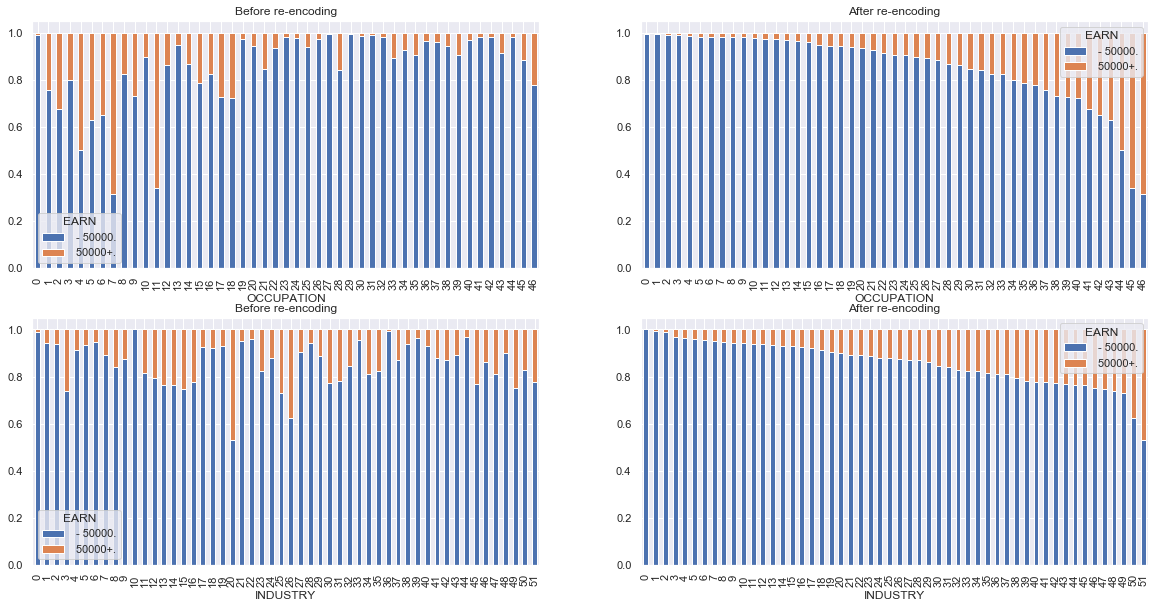

In [20]:
ls = ["OCCUPATION", 'INDUSTRY']
_, ax = plt.subplots(2, 2, figsize=(20,10))
for i,featureName in enumerate(ls): 
    # plot the count plot
    segemented_bar = get_segemented_bar(df_train[featureName],df_train['EARN'])
    segemented_bar.plot(kind='bar', stacked=True, title="Before re-encoding", ax = ax[int(i)][0])
    re_encode = re_order_encoding(df_train[featureName],df_train['EARN'])
    segemented_bar = get_segemented_bar(re_encode, df_train['EARN'])
    segemented_bar.plot(kind='bar', stacked=True, title="After re-encoding", ax = ax[int(i)][1])

plt.show()


In [21]:
ls = ["OCCUPATION", 'INDUSTRY']
for i,featureName in enumerate(ls): 
    # plot the count plot
    df_train[featureName] = re_order_encoding(df_train[featureName],df_train['EARN'])
    df_test[featureName] = re_order_encoding(df_test[featureName],df_test['EARN'])

<div class="alert alert-success">
**COMMENT**<br>
* ["OCCUPATION", 'INDUSTRY'] are nominal features but be encoded as real number in dataset, but  the numerical order of its encoding is totally random and don't represent the relationship with lablel distribution.

* we can use "One Hot" encoding to re-encoding this features again. But in our case,the range of real numbers are quite large, and one hot encoding will create (50+45) new columns, which will increase the the parameter need to be trained in our models.

* so here, i choose to re-encode them again as real number, but ensure the numerical order along with the label distribution.

### 3.3 Deal with the category Un-match before One-hot encoding (Labelencode)
<div class="alert alert-success">
**COMMENT**<br>
1. i tried to one hot encoding right after the previous state but got an error that the after-one-hot testset and trainset would have different number of colunms, which will prevent us to use the same model in both testset and trainset.

2. i dig into the problem and find out the reason is that: for feature HOUSEHOLD STATUS, trainset have 38 categories while in test only with 37.

3. To due with that we have two method:
    * change to use Labelencode
    * still use one hot encode, but after that add a new column in test set.
    
here i choose Labelencode for simplification.<br>
** Caveat :** the order when we do Labelencode is inportant, here i choose the order them mentioned in metadata for simplification reason, we could try other.

In [22]:
# find the features with different categories between train and test
ls_inmatch = []
for col in header:
    ls_inmatch.append(set(df_train[col].unique()) == set(df_test[col].unique()))
[df_train.columns[i] for i, x in enumerate(ls_inmatch) if not x ]

['WAGE', 'CAPGAIN', 'CAPLOSS', 'DIVIDENT', 'HOUSEHOLD STATUS', 'WEIGHT']

In [23]:
print("the number of category in train = {}, in test = {}".
      format(len (df_train['HOUSEHOLD STATUS'].unique()), len(df_test['HOUSEHOLD STATUS'].unique()) ))
print("different category is: ",set(df_train['HOUSEHOLD STATUS'].unique()) - set(df_test['HOUSEHOLD STATUS'].unique()))

the number of category in train = 38, in test = 37
different category is:  {' Grandchild <18 ever marr not in subfamily'}


In [24]:
# Labelencode
# create the encoder
features_encodings = {'HOUSEHOLD STATUS': [' Child <18 never marr not in subfamily',
                                           ' Other Rel <18 never marr child of subfamily RP',' Other Rel <18 never marr not in subfamily',' Grandchild <18 never marr child of subfamily RP',' Grandchild <18 never marr not in subfamily',' Secondary individual',' In group quarters',' Child under 18 of RP of unrel subfamily',' RP of unrelated subfamily',' Spouse of householder',' Householder',' Other Rel <18 never married RP of subfamily',' Grandchild <18 never marr RP of subfamily',' Child <18 never marr RP of subfamily',' Child <18 ever marr not in subfamily',' Other Rel <18 ever marr RP of subfamily'
                                           ,' Child <18 ever marr RP of subfamily',' Nonfamily householder',' Child <18 spouse of subfamily RP',' Other Rel <18 spouse of subfamily RP',' Other Rel <18 ever marr not in subfamily',' Grandchild <18 ever marr not in subfamily',' Child 18+ never marr Not in a subfamily',' Grandchild 18+ never marr not in subfamily'
                                           ,' Child 18+ ever marr RP of subfamily',' Other Rel 18+ never marr not in subfamily',' Child 18+ never marr RP of subfamily',' Other Rel 18+ ever marr RP of subfamily',' Other Rel 18+ never marr RP of subfamily',' Other Rel 18+ spouse of subfamily RP',' Other Rel 18+ ever marr not in subfamily',' Child 18+ ever marr Not in a subfamily',' Grandchild 18+ ever marr not in subfamily',' Child 18+ spouse of subfamily RP',' Spouse of RP of unrelated subfamily',' Grandchild 18+ ever marr RP of subfamily',' Grandchild 18+ never marr RP of subfamily',' Grandchild 18+ spouse of subfamily RP']}

encoder = LabelEncoder()

encoder.fit(features_encodings['HOUSEHOLD STATUS'])

# encode the train data
df_train['HOUSEHOLD STATUS'] = encoder.transform(df_train['HOUSEHOLD STATUS'])

# encode the test data
df_test['HOUSEHOLD STATUS'] = encoder.transform(df_test['HOUSEHOLD STATUS'])

### 3.3 One-hot encoding

In [25]:
# separate the features and label
# +50k = 1
label_zero = df_train['EARN'][0]
df_train['EARN'] = df_train['EARN'].apply(lambda c: 0 if c == label_zero else 1)
df_test['EARN'] = df_test['EARN'].apply(lambda c: 0 if c == label_zero else 1)

In [26]:
df_train_one_hot = pd.get_dummies(df_train)
df_test_one_hot = pd.get_dummies(df_test)

print("number of the features : ", len(df_test_one_hot.columns))
print("if train, test have the same columns: ", len(df_train_one_hot.columns) == len(df_test_one_hot.columns))

number of the features :  368
if train, test have the same columns:  True


In [27]:
Y_train = df_train_one_hot.pop("EARN")
X_train = df_train_one_hot.copy()
Y_test = df_test_one_hot.pop("EARN")
X_test = df_test_one_hot.copy()

<div class="alert alert-success">
**COMMENT**<br>

there more enigeering could be done here:
0. Labelencode
1. compute the correlation matrix(using Labelencode to categorical to numerical first), then
 * remove those features has little correlation with label
 * combine or reduce those features that are high corelated to each other (otherwise we will count the same fact many times)
2. Use linear function or polynomial function to combine original features to get new features, if the label-features correlation of the new features is higher, we keep them. 
3. remove outlier in dataset
4. Normalization the features distribution (QQplot)
5. Scaling feature


But since they need to look into each feature for analysis and is time consuming, i skip it in this test.

## 4. Build baseline models

<div class="alert alert-success">
**COMMENT**<br>
we need to think about :
 * how to choose hyperparameter
 * avoid overfitting<br>
 
I choose 5-folder Cross_Validation to deal with them.<br>
for time saving, I just search through a small hyperparameter space, just for illustration.

In [50]:
def get_best_model_CV(model, params):
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, Y_train)
    best_model = clf.best_estimator_
    clf.best_estimator_.fit(X_train, Y_train)
    predictions = clf.predict(X_train)
    print("the best parameters is: ", clf.best_params_)
    print("the best accuracry is: ", metrics.accuracy_score(Y_train,  predictions))
    print("The best model predict on the whole TRAIN SET \n",
      classification_report(Y_train,  predictions))
    return best_model

#### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
params= {"penalty":('l1', 'l2'), "C":[0.01, 0.1, 1]}
model = LogisticRegression()
logistic_model = get_best_model_CV(model, params)

the best parameters is:  {'C': 0.1, 'penalty': 'l2'}
the best accuracry is:  0.9530580434335891
The best model predict on the whole TRAIN SET 
              precision    recall  f1-score   support

          0       0.96      0.99      0.98    187141
          1       0.73      0.39      0.51     12382

avg / total       0.95      0.95      0.95    199523



#### AdaBoostClassifier

In [53]:
from sklearn.ensemble import AdaBoostClassifier
params= {"n_estimators":[50,100,200], "learning_rate":[0.5,1], 'algorithm' : ['SAMME', 'SAMME.R']}
model = AdaBoostClassifier()
boost_model = get_best_model_CV(model, params)

the best parameters is:  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}
the best accuracry is:  0.9549074542784541
The best model predict on the whole TRAIN SET 
              precision    recall  f1-score   support

          0       0.96      0.99      0.98    187141
          1       0.74      0.42      0.54     12382

avg / total       0.95      0.95      0.95    199523



#### A Fully connected Neural Network by Keras

In [63]:
def Binary_FCNN():
    # create model
    model = Sequential()
    model.add(Dense(units=200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=100, activation='relu', kernel_initializer='normal'))
    model.add(Dense(units=10, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
# CV to find the hyperparameters
estimator = KerasClassifier(build_fn = Binary_FCNN, epochs=35, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, X_train, Y_train, cv = kfold, scoring = "f1")
print("f1_score: " ,results)

f1_score:  [0.5149894  0.49845456]


In [70]:
FCNN_model = Binary_FCNN()
FCNN_model.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
199523/199523 [==============================] - 16s 79us/step - loss: 0.1546 - acc: 0.9379
Epoch 2/15
199523/199523 [==============================] - 15s 76us/step - loss: 0.1398 - acc: 0.9394
Epoch 3/15
199523/199523 [==============================] - 14s 72us/step - loss: 0.1346 - acc: 0.9472
Epoch 4/15
199523/199523 [==============================] - 15s 75us/step - loss: 0.1314 - acc: 0.9490
Epoch 5/15
199523/199523 [==============================] - 15s 75us/step - loss: 0.1301 - acc: 0.9501
Epoch 6/15
199523/199523 [==============================] - 15s 73us/step - loss: 0.1299 - acc: 0.9495
Epoch 7/15
199523/199523 [==============================] - 14s 70us/step - loss: 0.1294 - acc: 0.9499
Epoch 8/15
199523/199523 [==============================] - 15s 77us/step - loss: 0.1285 - acc: 0.9499
Epoch 9/15
199523/199523 [==============================] - 16s 80us/step - loss: 0.1280 - acc: 0.9501
Epoch 10/15
199523/199523 [==============================] - 15s 74us/ste

<div class="alert alert-success">
**COMMENT**<br>
since we use cross entropy loss for the sigmoid out put, the output is the Probability for class = 1, here for simplification i choose the threshold as 0.5, which could be tuning for higher F1.

In [91]:
predictions = FCNN_model.predict(X_train, batch_size=32)
predict_labels = [1 if i>0.5 else 0 for i in predictions]
print("accuracry predict on whole TRAIN SET : ", metrics.accuracy_score(Y_train,  predict_labels))
print("predict on the whole TRAIN SET \n",
  classification_report(Y_train,  predict_labels))

accuracry predict on whole TRAIN SET :  0.9505320188649931
predict on the whole TRAIN SET 
              precision    recall  f1-score   support

          0       0.96      0.99      0.97    187141
          1       0.67      0.39      0.50     12382

avg / total       0.94      0.95      0.94    199523



<div class="alert alert-success">
**COMMENT**<br>
there are also quite a lot hyperparamters we can tuning in NN:
 * the number of layers, the number of units in each layer, the actication function, learning rate, etc
 * we can also use cross validation to choose from these parameter.
but here I just skip this step for time saving.

Another problem here is that,as we use one-hot encoding those categorical features generate a lot one-hot columns.
In our case **360 one hot features vs 7 numerical features**. Therefore will the one hot features will dominate our Neural Net, and may alleviate the information in numerical features.

we can use other encoding like binary encoding and hashing encode to deal with it. But for time reason, i Skip here.

### 5. Predict on test set
* from above, the best model so far is AdaBoostClassifier

In [93]:
boost_model.fit(X_train, Y_train)
predictions  = boost_model.predict(X_test)
print("accuracry predict on TEST SET : ", metrics.accuracy_score(Y_test,  predictions))
print("predict on the TEST SET: \n",
  classification_report(Y_test,  predictions))

accuracry predict on TEST SET :  0.9547723582125459
predict on the TEST SET: 
              precision    recall  f1-score   support

          0       0.96      0.99      0.98     93576
          1       0.73      0.43      0.54      6186

avg / total       0.95      0.95      0.95     99762



<div class="alert alert-success">
**The Challenges for Me**<br>

1.Given the features types and the label types, what is the best approach to visualize them.
 * since many features have a large category(value) space, I choose **Histogram** to visualize their distribution.
 * since the the label is binary class, I **choose segmented bar** chart and **boxplot** for analyzing the conditional distribution of label given feature.<br>

2.After we got the relationship and characteristic of features, how we interpret what we found, how we do the feature engineering based on first step. ** And I think that is the part I should put more time on in this test, and this part will be the most important part for our result. ** <br>

Due to the time limitation, I haven't try a lot other feature engineering. What i could improve is that: 
* fine-labelencode all 40 features to real number, and compute the correlation matrix to select combine feature.
* find and remove the outliers in data
* try other encoding like binary encoding to reduce the number of colunms.


3.How we choose the hyperparameters for baseline models, thought we could use GridSearchCV, but it is time consuming and need us to provide a initial range for search. how we choose a reasonable search range.

4.How we choose a right metric to evalutate our model, in our First step, we found the label is very imbalanced, so we choose the F1-score.

5. how to deal with overfiting: regulation